# Introduction to Kinetic Modelling in PET

This tutorial introduces students to the fundamentals of kinetic modelling in PET. We will perform the following tasks to illustrate some of the key concepts:


1.  Read and plot simulated [<sup>18</sup>F]FDG PET time-activity curves (TACs) representing the blood input function, $C_p$, and tissue curve, $C_t$.
2.  Perform nonlinear least-squares fitting of a 1-tissue compartment model to the $[C_p,C_t]$ data.
3.  Repeat using a 2-tissue compartment model.
4.  Compare the model fits by analysing residuals and the Akaike Information Criterion (AIC).
5.  Perform Patlak graphical model fitting to the same data and compare estimates of the net influx rate constant, $K_i$, by Patlak and least squares.
6.  Analyse mouse brain TACs for the reversible D<sub>2</sub> receptor-binding ligand, [<sup>18</sup>F]Fallypride.
7.  Analyse the [<sup>18</sup>F]Fallypride data using the Logan plot.

On completion of these tasks we will summarise how this activity reinforced the student's understanding of the key concepts in PET kinetic modelling.





## Task 1: Read the data from a CSV file and plot the TACs

In [2]:
# import necessary modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import colors
from IPython.display import display, HTML
from scipy.interpolate import interp1d
from scipy.optimize import least_squares
from scipy.integrate import cumulative_trapezoid
from scipy import stats
from google.colab import files

In [3]:
# prompt the user to select a CSV file from a local directory, open it and read 4 columns of data into 4 variables
# the names of the variables are in the first row

uploaded = files.upload()
file_path = list(uploaded.keys())[0]
df = pd.read_csv(file_path)

# Check if the DataFrame has at least 4 columns
if df.shape[1] < 4:
    print("Error: The uploaded CSV file must have at least 4 columns.")
else:
    # Read the first 4 columns with the first row as variable names
    col_names = df.columns[:4]
    mid_frame_time = df.iloc[:, 0].to_numpy()
    frame_dur = df.iloc[:, 1].to_numpy()
    Cp = df.iloc[:, 2].to_numpy()
    Ct = df.iloc[:, 3].to_numpy()

Saving noisy_FDG_data.csv to noisy_FDG_data.csv


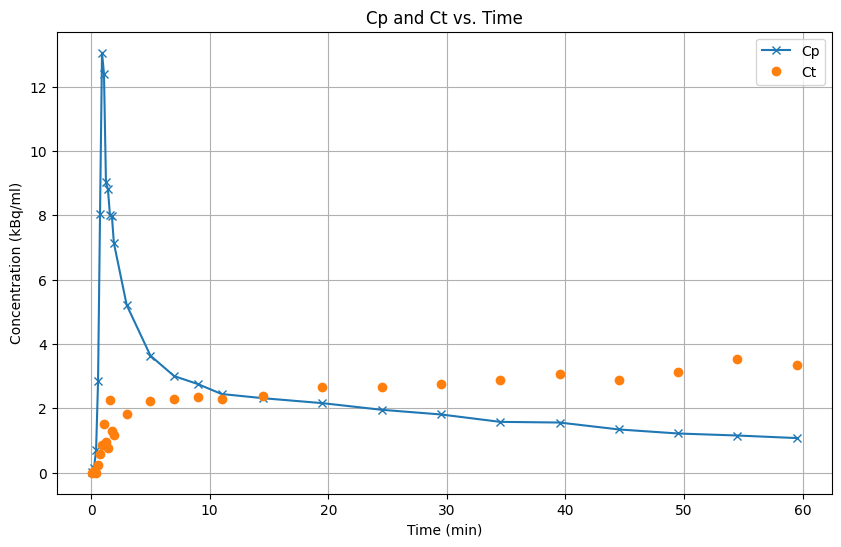

In [4]:
# plot Cp and Ct as a function of mid_frame_time

plt.figure(figsize=(10, 6)) # Adjust figure size as needed
plt.plot(mid_frame_time, Cp, marker='x', label='Cp')
plt.plot(mid_frame_time, Ct, 'o', label='Ct')
plt.xlabel('Time (min)')
plt.ylabel('Concentration (kBq/ml)')
plt.title('Cp and Ct vs. Time')
plt.legend()
plt.grid(True)
plt.show()

## Task 2: Perform least squares fitting of a 1-tissue compartment model

In [5]:
# first we need to resample Cp and Ct into uniformly spaced time intervals using bi-linear interpolation

# Create a uniform time interval with 1000 uniformly spaced time points
sample_size = 1000
uniform_time = np.linspace(mid_frame_time.min(), mid_frame_time.max(), sample_size)

# Create interpolation functions for Cp and Ct using bi-linear method ('linear')
interp_cp = interp1d(mid_frame_time, Cp, kind='linear')
interp_ct = interp1d(mid_frame_time, Ct, kind='linear')

# Resample Cp and Ct using the uniform time intervals
resampled_Cp = interp_cp(uniform_time)
resampled_Ct = interp_ct(uniform_time)

One tissue compartment model:
$$\frac{dC_t}{dt}=K_1C_p-k_2C_t.$$

Operational model equation:
$$C_t=\int_o^tC_p(\tau)K_1e^{-k_2(t-\tau)}d\tau.$$

PET TAC taking $V_b$ into account:
$$C^{model}_t=(1-V_b)C_t+V_bC_p.$$

In [6]:
# define the 1-tissue compartment model
def one_tissue_model(t, Cp, K1, k2, Vb):
    """ Return model-fitted tissue TAC for given parameters """
    dt   = t[1] - t[0]                         # assume uniform spacing
    irf  = K1 * np.exp(-k2 * t)                # impulse response function
    Ct   = np.convolve(Cp, irf)[:len(t)] * dt  # causal part only
    Ct_model = (1 - Vb) * Ct + Vb * Cp
    return Ct_model

# define the residual
def one_tcm_residual(theta, t, Cp, Ct_obs):
    """ Return residuals between model-predicted and observed TACs """
    Ct_model = one_tissue_model(t, Cp, *theta)
    return Ct_model - Ct_obs

# define the callback function for operations at each iteration
def make_callback_one_tcm(uniform_time, resampled_Cp, resampled_Ct,
                          mid_frame_time, Ct, *, plot_every=1, alpha_old=1):
    """
    Returns a callback that updates the 1-TCM fit plot
    iterations of scipy.optimize.least_squares.
    """
    iter_no = 0

    plt.ion()
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(mid_frame_time, Ct, "o", label="Observed TAC")
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel("Concentration (kBq/ml)")

    norm  = colors.Normalize(vmin=1, vmax=29)
    cmap  = mpl.colormaps["Reds"]

    def callback(xk, *state):
        nonlocal iter_no
        iter_no += 1
        if iter_no % plot_every:
            return

        Ct_hat = one_tissue_model(uniform_time, resampled_Cp, *xk)

        if iter_no > norm.vmax:
            norm.vmax = iter_no
        colour = cmap(norm(iter_no) + 0.2)
        ax[0].plot(uniform_time, Ct_hat, alpha=alpha_old, color=colour, lw=1.5,
                label=f"iter {iter_no}")
        ax[0].set_title(f"One-Tissue Compartment Model Fit")
        ax[0].legend(loc="best", fontsize=8)

        nearest_indices = np.abs(uniform_time[:, None] - mid_frame_time).argmin(axis=0)
        Cmodel = Ct_hat[nearest_indices]
        residuals = Cmodel - Ct
        ax[1].cla()
        ax[1].set_title(f'Residuals (Model - Observed): iteration {iter_no}')
        ax[1].set_xlabel('Time (min)')
        ax[1].set_ylabel('Difference (kBq/ml)')
        ax[1].plot(mid_frame_time, residuals, 'o', label='residuals')
        ax[1].legend(loc="best", fontsize=8)
        fig.canvas.draw_idle()

    return callback

In [7]:
# prompt the user for starting estimates of the model parameters K1, k2, k3, k4 and Vb

K1 = 0.12 #@param {type:"number"}
k2 = 0.2 #@param {type:"number"}
Vb = 0.05 #@param {type:"number"}

No. of iterations    : 15


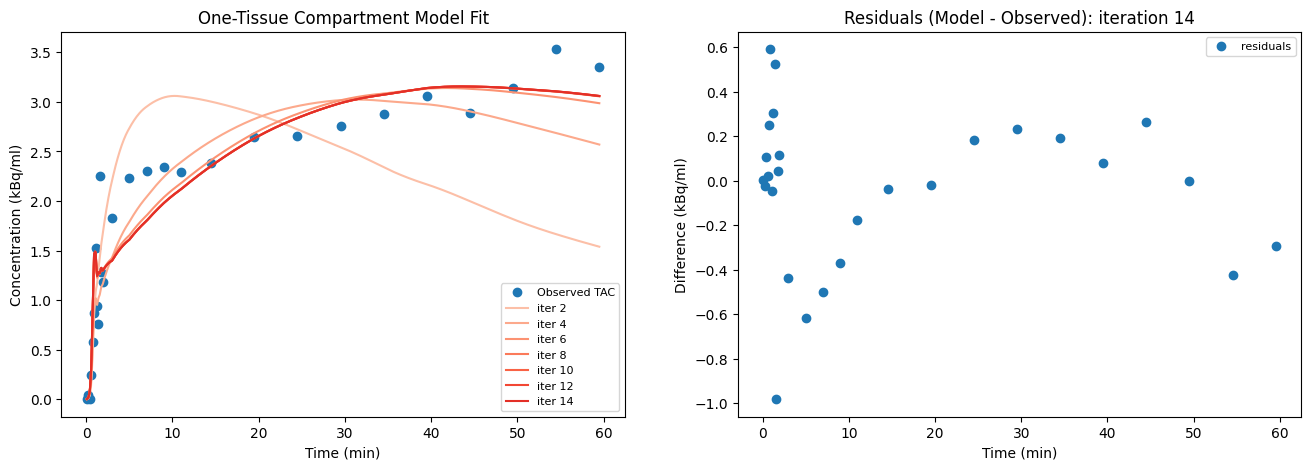

In [8]:
x0   = [K1, k2, Vb]                             # initial guess
lower, upper = (0, 0, 0), (np.inf, np.inf, 0.1) # boundary conditions

# perform least squares fitting of model to Ct
callback_1tcm = make_callback_one_tcm(uniform_time, resampled_Cp, resampled_Ct,
                                      mid_frame_time, Ct, plot_every=2) # update every 2 iterations
result = least_squares(
    one_tcm_residual, x0,
    args=(uniform_time, resampled_Cp, resampled_Ct),
    bounds=(lower, upper),
    method='trf',              # default; works well for most PET fits
    loss='soft_l1',            # loss function, more robust to noise
    callback=callback_1tcm,    # calls callback at each iteration
    xtol=1e-12, ftol=1e-12
)
one_tcm_pred = one_tissue_model(uniform_time, resampled_Cp, *result.x)
one_tcm_results = {
    "K1": result.x[0],
    "k2": result.x[1],
    "Vb": result.x[2],
}
print("No. of iterations    :", result.nfev)

# compute residuals
nearest_indices = np.abs(uniform_time[:, None] - mid_frame_time).argmin(axis=0)
Cmodel = one_tcm_pred[nearest_indices]
residuals = Cmodel - Ct

# calculate AIC
n = resampled_Ct.size
k = result.x.size
RSS = np.dot(result.fun, result.fun)
AIC = n * np.log(RSS/n) + 2 * k

In [9]:
# diaplay paremeter estimates
html_output = f"""
<div style="border: 1px solid black; padding: 10px; font-size: 24px;">
    <b> K<sub>1</sub>:</b> {one_tcm_results["K1"]:.3f} <br>
    <b> k<sub>2</sub>:</b> {one_tcm_results["k2"]:.3f} <br>
    <b> V<sub>b</sub>:</b> {one_tcm_results["Vb"]:.3f} <br>
    <b> AIC:</b> {AIC:.1f}
"""
display(HTML(html_output))

## Task 3: Perform least squares fitting of a 2-tissue compartment model

Two tissue compartment model:

$$\frac{dC_f}{dt}=K_1C_p-k_2C_f-k_3C_f+k_4C_m,$$
$$\frac{dC_m}{dt}=k_3C_f-k_4C_m.$$

Solution via Laplace transform leads to the following operational equation:

$$C^{model}_t=(1-V_b)\frac{K_1}{\alpha_2-\alpha_1}[(k_3+k_4-\alpha_1)e^{-\alpha_1t} - (k_3+k_4-\alpha_2)e^{-\alpha_2t}]*C_p+V_bC_b,$$

where $*$ denotes the convolution operation, and $\alpha_{1,2}=\frac{1}{2}(k_2+k_3+k_4\mp\sqrt{(k_2+k_3+k_4)^2-4k_2k_4})$.

In [11]:
# define the 2-tissue compartment model
def two_tissue_model(t, Cp, K1, k2, k3, k4, Vb):
    """ Return modelled tissue curve Ct(t) for given parameters """
    dt   = t[1] - t[0]                         # assume uniform spacing
    part1 = k2 + k3 + k4
    alpha1 = 1 / 2 * (part1 - np.sqrt(part1 ** 2 - 4 * k2 * k4))
    alpha2 = 1 / 2 * (part1 + np.sqrt(part1 ** 2 - 4 * k2 * k4))
    part2 = K1 / (alpha2 - alpha1)
    theta1 = part2 * (k3 + k4 - alpha1)
    theta2 = part2 * (k3 + k4 - alpha2)
    irf  = theta1 * np.exp(-alpha1 * t) - theta2 * np.exp(-alpha2 * t)
    Ct_model = (1 - Vb)*np.convolve(Cp,irf)[:len(t)]*dt + Vb*Cp
    return Ct_model, irf

# define the residual
def two_tcm_residual(theta, t, Cp, Ct_obs):
    """  Return residuals between model-predicted Ct and observed Ct """
    Ct_model, _ = two_tissue_model(t, Cp, *theta)
    return Ct_model - Ct_obs

# define the callback function for operations at each iteration
def make_callback_two_tcm(uniform_time, resampled_Cp, resampled_Ct,
                          mid_frame_time, Ct, *, plot_every=1, alpha_old=1,
                          all_in_one=True):
    """
    Returns a callback that updates the 2-TCM fit plot
    iterations of scipy.optimize.least_squares.
    """
    iter_no = 0

    plt.ion()
    fig, ax = plt.subplots(1, 2, figsize=(16, 5))
    ax[0].plot(mid_frame_time, Ct, "o", label="Observed TAC")
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel("Concentration (kBq/ml)")

    norm  = colors.Normalize(vmin=1, vmax=29)
    cmap  = mpl.colormaps["Reds"]

    def callback(xk, *state):
        nonlocal iter_no
        iter_no += 1
        if iter_no % plot_every:
            return

        Ct_hat, _ = two_tissue_model(uniform_time, resampled_Cp, *xk)

        if iter_no > norm.vmax:
            norm.vmax = iter_no
        colour = cmap(norm(iter_no) + 0.2)
        ax[0].plot(uniform_time, Ct_hat, alpha=alpha_old, color=colour, lw=1.5,
                label=f"iter {iter_no}")
        ax[0].set_title(f"Two-Tissue Compartment Model Fit")
        ax[0].legend(loc="best", fontsize=8)

        nearest_indices = np.abs(uniform_time[:, None] - mid_frame_time).argmin(axis=0)
        Cmodel = Ct_hat[nearest_indices]
        residuals = Cmodel - Ct
        ax[1].cla()
        ax[1].set_title(f'Residuals (Model - Observed): iteration {iter_no}')
        ax[1].set_xlabel('Time (min)')
        ax[1].set_ylabel('Difference (kBq/ml)')
        ax[1].plot(mid_frame_time, residuals, 'o', label='residuals')
        ax[1].legend(loc="best", fontsize=8)
        fig.canvas.draw_idle()

    return callback

In [12]:
# prompt the user for starting estimates of the model parameters K1, k2, k3, k4 and Vb

#@title Starting Estimates
K1 = 0.15 #@param {type:"number"}
k2 = 0.22 #@param {type:"number"}
k3 = 0.48 #@param {type:"number"}
k4 = 0.045 #@param {type:"number"}
Vb = 0.03 #@param {type:"number"}

print(f"Starting estimates: K1={K1}, k2={k2}, k3={k3}, k4={k4}, Vb={Vb}")

Starting estimates: K1=0.15, k2=0.22, k3=0.48, k4=0.045, Vb=0.03


No. of iterations            : 28


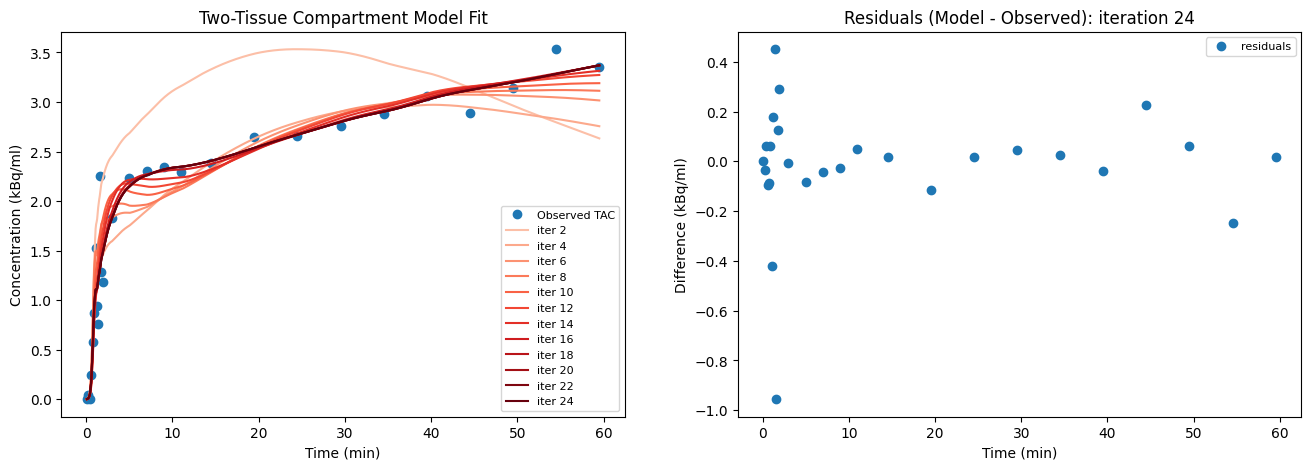

In [13]:
x0   = [K1, k2, k3, k4, Vb]                                          # initial guess
lower, upper = (0, 0, 0, 0, 0), (np.inf, np.inf, np.inf, 0.1, 0.1)   # boundary conditions

# perform least squares fitting of model to Ct
callback_2tcm = make_callback_two_tcm(uniform_time, resampled_Cp, resampled_Ct,
                                      mid_frame_time, Ct, plot_every=2) # update every 2 iterations
result = least_squares(
    two_tcm_residual, x0,
    args=(uniform_time, resampled_Cp, resampled_Ct),
    bounds=(lower, upper),
    method='trf',              # default; works well for most PET fits
    loss='soft_l1',            # loss function, more robust to noise
    callback=callback_2tcm,    # calls callback at each iteration
    xtol=1e-12, ftol=1e-12
)
two_tcm_pred, irf = two_tissue_model(uniform_time, resampled_Cp, *result.x)
two_tcm_results = {
    "K1": result.x[0],
    "k2": result.x[1],
    "k3": result.x[2],
    "k4": result.x[3],
    "Vb": result.x[4]
}
print("No. of iterations            :", result.nfev)

# compute residuals
nearest_indices = np.abs(uniform_time[:, None] - mid_frame_time).argmin(axis=0)
Cmodel = two_tcm_pred[nearest_indices]
residuals = Cmodel - Ct

# calculate AIC
n = resampled_Ct.size
k = result.x.size
RSS = np.dot(result.fun, result.fun)
AIC = n * np.log(RSS/n) + 2 * k

In [14]:
# display paremeter estimates
html_output = f"""
<div style="border: 1px solid black; padding: 10px; font-size: 24px;">
    <b> K<sub>1</sub>:</b> {two_tcm_results["K1"]:.3f} <br>
    <b> k<sub>2</sub>:</b> {two_tcm_results["k2"]:.3f} <br>
    <b> k<sub>3</sub>:</b> {two_tcm_results["k3"]:.3f} <br>
    <b> k<sub>4</sub>:</b> {two_tcm_results["k4"]:.3f} <br>
    <b> V<sub>b</sub>:</b> {two_tcm_results["Vb"]:.3f} <br>
    <b> AIC:</b> {AIC:.1f}
"""
display(HTML(html_output))

## Task 4: Patlak graphical analysis

Tracer concentration in tissue, $C_t$, is assumed to be trapped in an irreversible terminal compartment:
 $$C_t(t)=K_i\int_0^tC_p(\tau)d\tau+V_0C_p(t)$$

where $K_i$ is the net influx rate, $C_p$ is the plasma input function and $V_0$ is the distribution volume of the reversible compartment(s).

Divide throughout by $C_p$ and we get the Patlak linear regression equation with slope = $K_i$ and intercept = $V_0$:

$$\frac{C_t(t)}{C_p(t)}=K_i\frac{\int_0^tC_p(\tau)d\tau}{C_p(t)}+V_0$$

In [15]:
# prompt user to enter t*, the starting time for linear regression
tstar = 15 #@param {type:"number"}

Slope     : 0.022690
Intercept : 0.485692
R²        : 0.984826
p-value   : 1.4586e-08


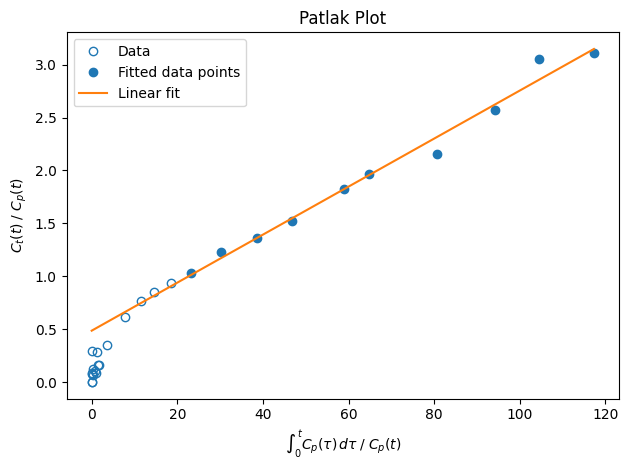

In [16]:
start_idx = np.abs(mid_frame_time - tstar).argmin()   # find the index where the time is closest to start time

AUC = cumulative_trapezoid(Cp, mid_frame_time, initial=0)  # ∫₀ᵗ Cp(τ)dτ
X   = AUC / Cp                                             # Patlak x‑axis
Y   = Ct / Cp                                              # Patlak y‑axis

x   = X[start_idx:]
y   = Y[start_idx:]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value ** 2
print(f"Slope     : {slope:.6f}")
print(f"Intercept : {intercept:.6f}")
print(f"R²        : {r_squared:.6f}")
print(f"p-value   : {p_value:.4e}")

# calculate Ki from the 2TCM
two_tcm_Ki = two_tcm_results["K1"] * two_tcm_results["k3"] / (two_tcm_results["k2"] + two_tcm_results["k3"])
# calculate Ki from Patlak with blood volume correction
Patlak_Ki = slope / (1 - two_tcm_results["Vb"])

# visualise the Patlak plot
plt.figure()
#plt.plot(X, Y, 'o', label='Data')
plt.plot(X[0:start_idx], Y[0:start_idx], 'o', label='Data', mec='#1f77b4', mfc='none')
plt.plot(X[start_idx:], Y[start_idx:], 'o', label='Fitted data points', color='#1f77b4')
plt.plot(X, slope * X + intercept, '-', label='Linear fit')
plt.xlabel(r'$\int_0^t C_p(\tau)\,d\tau \; / \; C_p(t)$')
plt.ylabel(r'$C_t(t) \; / \; C_p(t)$')
plt.title('Patlak Plot')
plt.legend()
plt.tight_layout()
plt.show()

In [17]:
# diaplay Ki values from Patlak and 2TCM
html_output = f"""
<div style="border: 1px solid black; padding: 10px; font-size: 24px;">
    <b> 2TCM K<sub>i</sub>:</b> {two_tcm_Ki:.3f} <br>
    <b> Patlak K<sub>i</sub>:</b> {Patlak_Ki:.3f}
"""
display(HTML(html_output))

## Task 5: Analyse the IRF and it's relationship to the 2TCM parameters

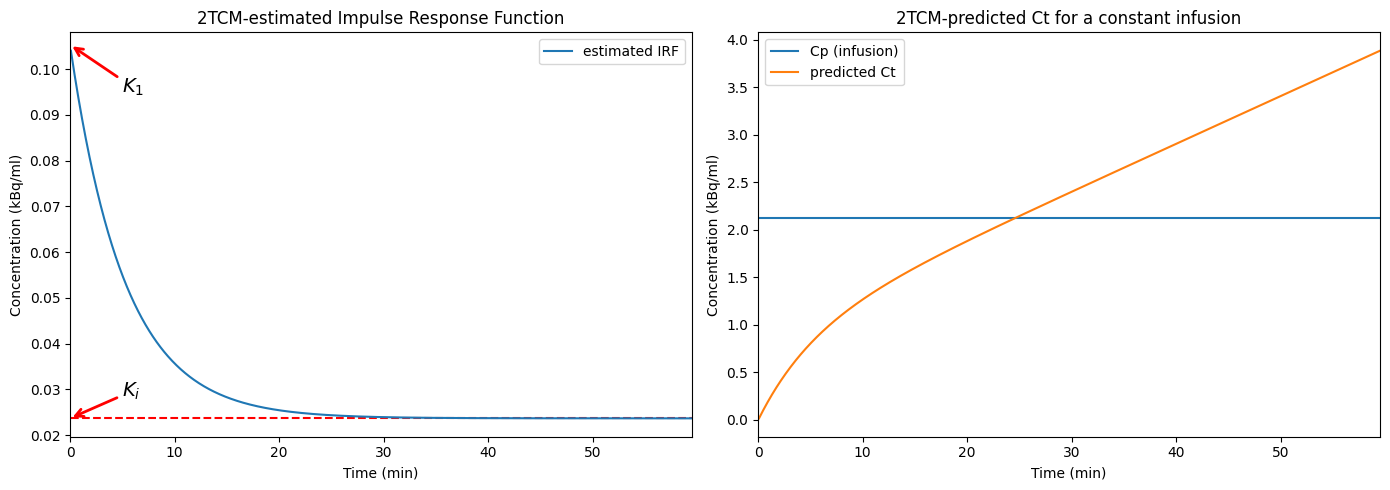

In [22]:
# Plot the IRF estimated by the 2TCM fit on the left
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
y = np.full(len(uniform_time), two_tcm_Ki, dtype=float)
axes[0].set_title('2TCM-estimated Impulse Response Function')
axes[0].set_xlabel('Time (min)')
axes[0].set_ylabel('Concentration (kBq/ml)')
axes[0].set_xlim(0,max(uniform_time))
axes[0].plot(uniform_time, y, linestyle='--', color='red')
axes[0].plot(uniform_time, irf, label='estimated IRF')
axes[0].legend()
axes[0].annotate(r'$K_1$', xy=(0, two_tcm_results["K1"]), xytext=(5, two_tcm_results["K1"]*0.9), arrowprops=dict(arrowstyle="->", lw=2, color='red'), fontsize=14, color='black')
axes[0].annotate(r'$K_i$', xy=(0, two_tcm_Ki), xytext=(5, two_tcm_Ki*1.2), arrowprops=dict(arrowstyle="->", lw=2, color='red'), fontsize=14, color='black')

# create a constant infusion input function
dt = uniform_time[1] - uniform_time[0]
Cp_infusion = np.ones_like(resampled_Cp)
Cp_infusion *= np.sum(resampled_Cp) / np.sum(Cp_infusion)   # normalise to same total as original Cp
Ct_infusion = np.convolve(Cp_infusion, irf)[:len(irf)] * dt # convolve with IRF

# Plot the predicted Ct from a constant infusion on the right
axes[1].set_title('2TCM-predicted Ct for a constant infusion')
axes[1].set_xlabel('Time (min)')
axes[1].set_ylabel('Concentration (kBq/ml)')
axes[1].set_xlim(0, max(uniform_time))
axes[1].plot(uniform_time, Cp_infusion, label='Cp (infusion)')
axes[1].plot(uniform_time, Ct_infusion, label='predicted Ct')
axes[1].legend()
plt.tight_layout()
plt.show()

### Q: What does the model-predicted $C_t$ for a constant infusion remind you of?

## Task 6: Open a new CSV file containing mouse [<sup>18</sup>F]Fallypride data and plot the TACs for the target (striatum) and reference (cerebellum) tissues, along with the striatum : cerebellum ratio

Saving Fallypride_M3.csv to Fallypride_M3 (1).csv


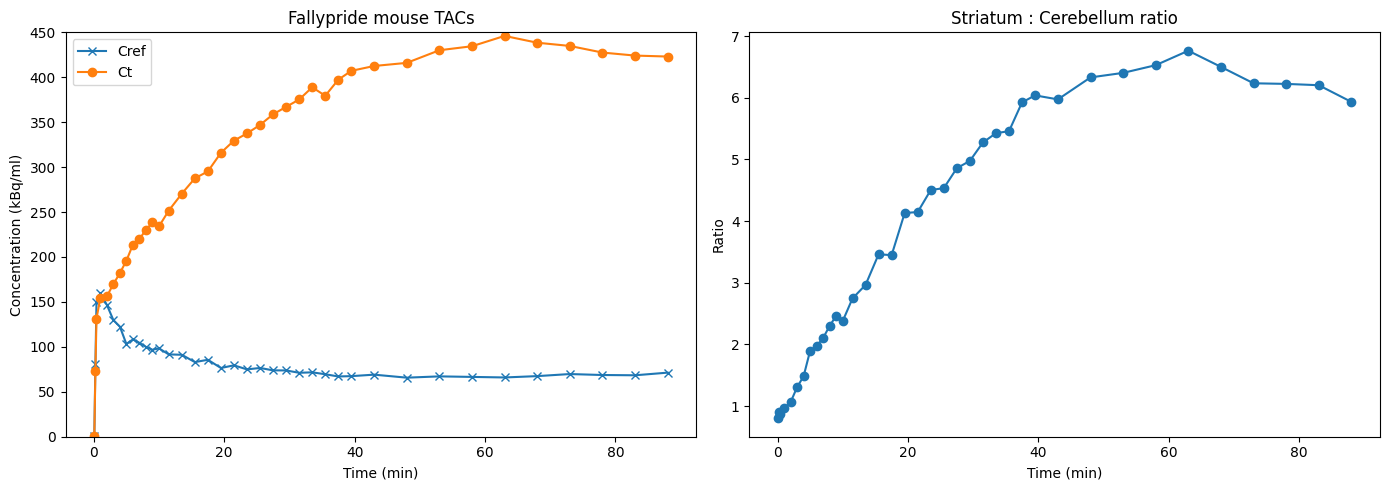

In [24]:
# prompt the user to select a CSV file from a local directory, open it and read 4 columns of data into 4 variables

uploaded = files.upload()
file_path = list(uploaded.keys())[0]
df = pd.read_csv(file_path)

# Check if the DataFrame has at least 4 columns
if df.shape[1] < 4:
    print("Error: The uploaded CSV file must have at least 4 columns.")
else:
    # Read the first 4 columns with the first row as variable names
    col_names = df.columns[:4]
    mid_frame_time = df.iloc[:, 0].to_numpy()
    frame_dur = df.iloc[:, 1].to_numpy()
    Cref = df.iloc[:, 2].to_numpy()
    Ct = df.iloc[:, 3].to_numpy()

# plot Cref and Ct as a function of mid_frame_time on the left

#plt.figure(figsize=(10, 6)) # Adjust figure size as needed
#plt.plot(mid_frame_time, Cref, marker='x', label='Cref')
#plt.plot(mid_frame_time, Ct, 'o', label='Ct')
#plt.xlabel('Time (min)')
#plt.ylabel('Concentration (kBq/ml)')
#plt.title('Fallypride mouse TACs')
#plt.legend()
#plt.grid(True)
#plt.show()

# plot Cref and Ct as a function of mid_frame_time on the left

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].set_title('Fallypride mouse TACs')
axes[0].set_xlabel('Time (min)')
axes[0].set_ylabel('Concentration (kBq/ml)')
axes[0].set_ylim(0,450)
axes[0].plot(mid_frame_time, Cref, marker='x', label='Cref')
axes[0].plot(mid_frame_time, Ct, marker='o', label='Ct')
axes[0].legend()

# plot the ratio of Ct:Cref on the right

axes[1].set_title('Striatum : Cerebellum ratio')
axes[1].set_xlabel('Time (min)')
axes[1].set_ylabel('Ratio')
axes[1].plot(mid_frame_time, Ct/Cref, marker='o')
plt.tight_layout()
plt.show()

## Task 7: Now compute a Logan plot and estimate the distribution volume ratio from the slope

Tracer concentration in tissue, $C_t$, is assumed to reversibly bind to receptor sites in the terminal compartment. We also assume there is a reference tissue devoid of specific binding sites, $C_{ref}$.

The linearised Logan equation is similar to Patlak but we normalise to $C_t$ rather than $C_p$ (or in this case $C_{ref}$):

$$\frac{\int_0^tC_t(\tau)d\tau}{C_t(t)}=\frac{V_T}{V_{ND}}\frac{\int_0^tC_{ref}(\tau)d\tau}{C_t(t)}+intercept$$

We perform linear regression to find the slope = $\frac{V_T}{V_{ND}}$ which is the distribution volume ratio (DVR). The DVR is related to the specific binding potential (relative to non-displaceable tracer), $BP_{ND}$, by:

$$BP_{ND}=DVR-1$$

In [25]:
# prompt user to enter t*, the starting time for linear regression
tstar = 15 #@param {type:"number"}

Slope     : 6.655889
R²        : 0.998719
p-value   : 7.3044e-32


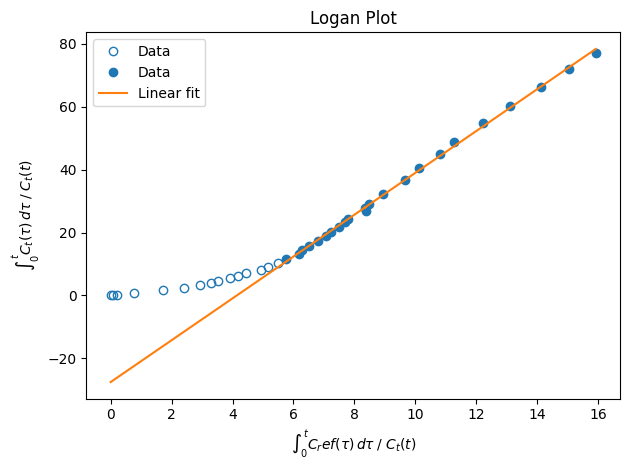

In [26]:
# set up the Logan plot
start_idx = np.abs(mid_frame_time - tstar).argmin()              # find the index where the time is closest to start time

CtAUC = cumulative_trapezoid(Ct, mid_frame_time, initial=0)      # ∫₀ᵗ Ct(τ)dτ
CrefAUC = cumulative_trapezoid(Cref, mid_frame_time, initial=0)  # ∫₀ᵗ Cref(τ)dτ
X   = CrefAUC / Ct                                               # Logan x‑axis
Y   = CtAUC / Ct                                                 # Logan y‑axis

x   = X[start_idx:]
y   = Y[start_idx:]

slope, intercept, r_value, p_value, std_err = stats.linregress(x, y)
r_squared = r_value ** 2
print(f"Slope     : {slope:.6f}")
print(f"R²        : {r_squared:.6f}")
print(f"p-value   : {p_value:.4e}")

# the DVR is equal to the slope of the Logan plot
DVR = slope

# visualise the Logan plot
plt.figure()
plt.plot(X[0:start_idx], Y[0:start_idx], 'o', label='Data', mec='#1f77b4', mfc='none')
plt.plot(X[start_idx:], Y[start_idx:], 'o', label='Data', color='#1f77b4')
plt.plot(X, slope * X + intercept, '-', label='Linear fit')
plt.xlabel(r'$\int_0^t C_ref(\tau)\,d\tau \; / \; C_t(t)$')
plt.ylabel(r'$\int_0^t C_t(\tau)\,d\tau \; / \; C_t(t)$')
plt.title('Logan Plot')
plt.legend()
plt.tight_layout()
plt.show()

# display paremeter estimates
html_output = f"""
<div style="border: 1px solid black; padding: 10px; font-size: 24px;">
    <b> DVR:</b> {DVR:.2f} <br>
    <b> BP<sub>ND</sub>:</b> {DVR-1:.2f}
"""
display(HTML(html_output))

### Q: Why is the DVR value so similar to the equilibrium striatum : cerebellum ratio in the previous plot?

## Extension: Re-run the Logan analysis above on the file Fallypride_M6.csv which contains TACs for a mouse who was administered EtOH

### Q: How does the DVR for the EtOH-treated mouse compare with the untreated mouse?
### Q: Why is it different?